# Multi-armed Bandits

A 10-arm bandit model is present. The mean rewards of each arm are sampled from the uniform distribution between [0, 1] and the rewards themselves are bernoulli (i.e. either 0 or 1) with provided mean probability. Task is to maximise reward over a horizon without knowing their mean values. <br>
The aim is to implement multiple models to solve the multi-arm bandit problem and compare their performance <br>
Model used are-<br>
1. $\epsilon$ - greedy Method and Variants
2. UCB
3. KL-UCB
4. Gradient Bandit
5. Thompson Sampling

#### Importing Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### Setting Mean Rewards for each arm

In [2]:
np.random.seed(2)
n = 10
mean_reward = np.array([x for x in np.random.uniform(0, 1, n)])

In [3]:
df = pd.DataFrame()
df["Arm"] = np.array(range(1,n+1))
df["Mean Reward"] = mean_reward
df

,Arm,Mean Reward
0,1,0.435995
1,2,0.025926
2,3,0.549662
3,4,0.435322
4,5,0.420368
5,6,0.330335
6,7,0.204649
7,8,0.619271
8,9,0.299655
9,10,0.266827


#### Useful Plotting Functions

In [4]:
def learning_plot(x, y, maxReward, avgReward):
    ymax = maxReward * np.ones_like(y)
    yavg = avgReward * np.ones_like(y)
    plt.figure()
    plt.plot(x, y)
    plt.plot(x, ymax)
    plt.plot(x, yavg)    
    plt.title("Learning Curve")
    plt.xlabel("Time Steps")
    plt.ylabel("Reward")
    plt.legend(["Actual Reward", "Optimal Reward", "Average Reward"])
    plt.show()

def regret_plot (x, y, maxReward):
    ymax = maxReward * np.ones_like(y)
    regret = np.zeros(len(x))
    ratio = np.zeros(len(x))
    regret[0] = ymax[0] - y[0]
    ratio[0] = regret[0]
    for i in range(1, len(x)):
        regret[i] = regret[i-1] + (ymax[i] - y[i])
        ratio[i] = regret[i] / i
    plt.figure()
    plt.title("Regret Curve")
    plt.xlabel("Time Steps")
    plt.ylabel("Regret")
    plt.plot(x, regret)
    plt.figure()
    plt.title("Regret / T Curve")
    plt.xlabel("Time Steps")
    plt.ylabel("Regret(T) / T Ratio")
    plt.plot(x, ratio)
    plt.show()

## $\epsilon$ - Greedy Method

In [5]:
class eps_greedy:
    def __init__(self, means, variant = 1, T = 1000, eps = 0.2):
        if (T == 0):
            print("INVALID Horizon! Using default Horizon = 1000 timesteps")
            T = 1000
            
        if (variant != 1 and variant != 2 and variant != 3):
            print("INVALID Variant Number! Using default Variant 1")
            variant = 1
        
        self.initialisation(means, T, variant, eps)
        
        if (variant == 1 or variant == 2):
            self.compute_type1()
        else:
            self.compute_type2()
        self.optimal()

    def initialisation (self, means, T, variant, eps):
        self.T = T
        self.means = means
        self.n = len(means)
        
        if (variant == 1):
            self.eps = eps
        elif (variant == 2):
            self.eps = 1 / np.sqrt(self.T)
        else:
            self.eps = 1
        
        self.prob = np.ones(self.n) / float(self.n)
        
        self.total_reward = 0
        self.emp_mean = np.zeros(self.n)
        self.Na = np.zeros(self.n)
        self.x = np.array(range(self.T))
        self.y = np.zeros(self.T)

    def compute_type1 (self):
        for t in range(self.T):
            a = np.random.choice(range(self.n), p=self.prob)
            r = np.random.choice([0,1], p=[1 - self.means[a], self.means[a]])

            self.total_reward += r
            self.emp_mean[a] = (self.Na[a] * self.emp_mean[a] + r)/ (self.Na[a] + 1)
            self.Na[a] += 1
            self.y[t] = np.dot(self.prob, self.emp_mean)
            
            self.prob = np.ones(self.n) * (self.eps / self.n)
            self.prob[np.argmax(self.emp_mean)] += 1 - self.eps
            
    def compute_type2 (self):
        for t in range(self.T):
            a = np.random.choice(range(self.n), p=self.prob)
            r = np.random.choice([0,1], p=[1 - self.means[a], self.means[a]])

            self.total_reward += r
            self.emp_mean[a] = (self.Na[a] * self.emp_mean[a] + r)/ (self.Na[a] + 1)
            self.Na[a] += 1
            self.y[t] = np.dot(self.prob, self.emp_mean)
            
            self.eps = 1/(0.5*t+2)
            self.prob = np.ones(self.n) * (self.eps / self.n)
            self.prob[np.argmax(self.emp_mean)] += 1 - self.eps
    
    def optimal(self):
        opt_arm = np.argmax(self.emp_mean)
        print("The optimal Arm Number: ", opt_arm + 1, "\nMean_reward of optimal arm: ", self.means[opt_arm])

    def plots(self):
        learning_plot(self.x, self.y, max(self.means), np.mean(self.means))
        regret_plot(self.x, self.y, max(self.means))

### Variant-1: Constant $\epsilon$

In [6]:
model1 = eps_greedy(mean_reward, variant = 1, T = 100000, eps = 0.2)

The optimal Arm Number:  8 
Mean_reward of optimal arm:  0.6192709663506637


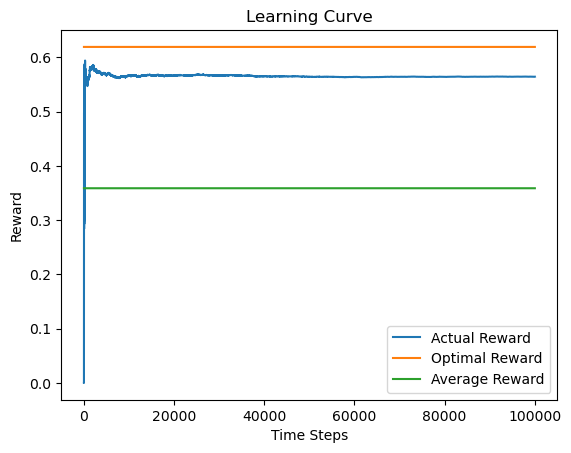

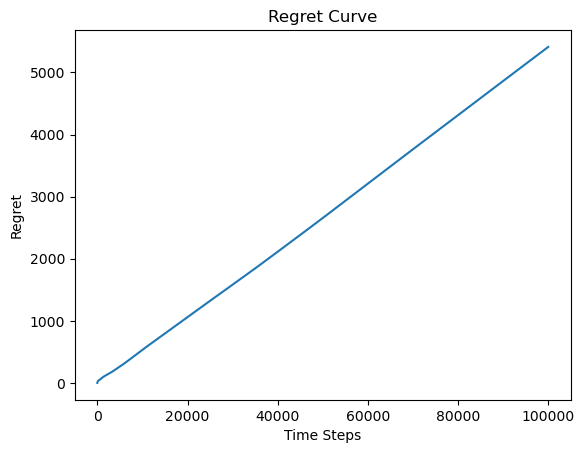

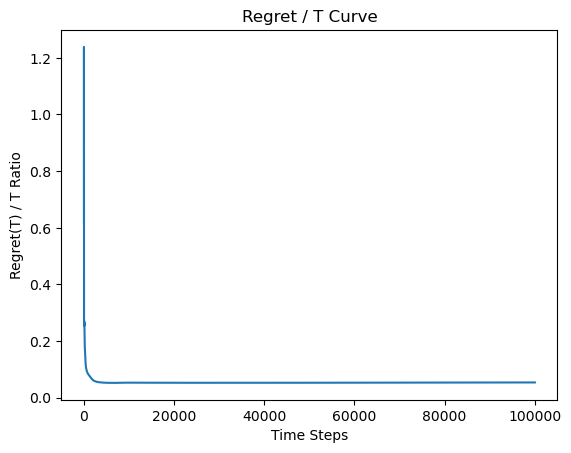

In [7]:
model1.plots()

### Variant-2 : $\epsilon = \frac{1}{\sqrt{T}}$

In [8]:
model2 = eps_greedy(mean_reward, variant = 2, T = 100000)

The optimal Arm Number:  8 
Mean_reward of optimal arm:  0.6192709663506637


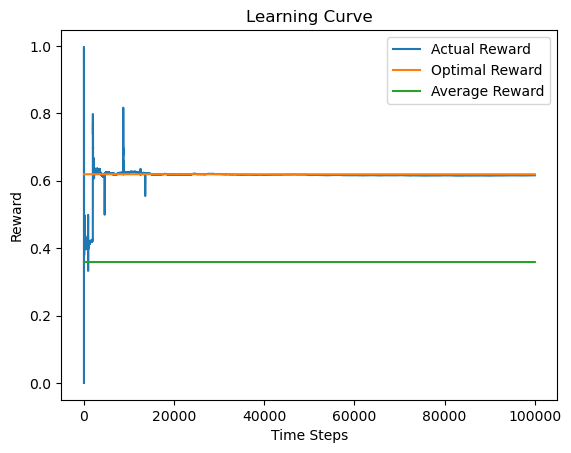

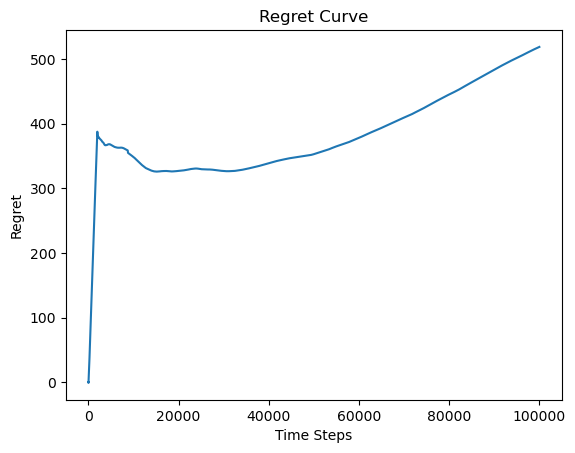

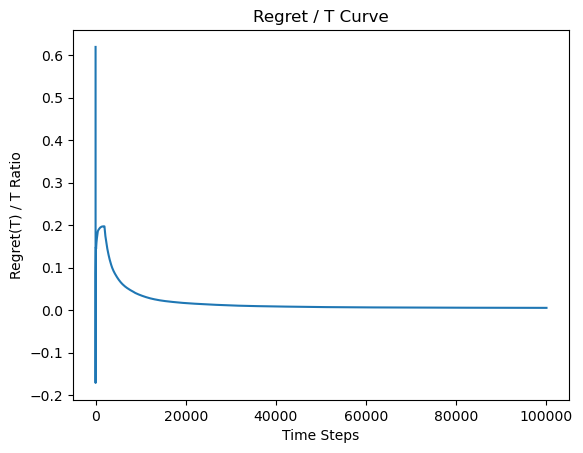

In [9]:
model2.plots()

### Variant-3: $\epsilon = \frac{1}{0.5t+1}$

In [10]:
model3 = eps_greedy(mean_reward, variant = 3, T = 100000)

The optimal Arm Number:  8 
Mean_reward of optimal arm:  0.6192709663506637


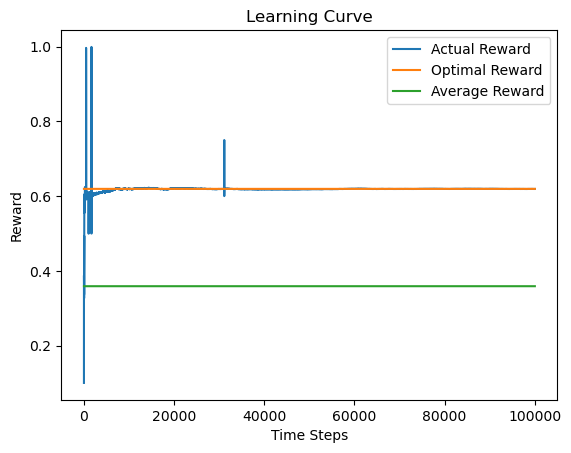

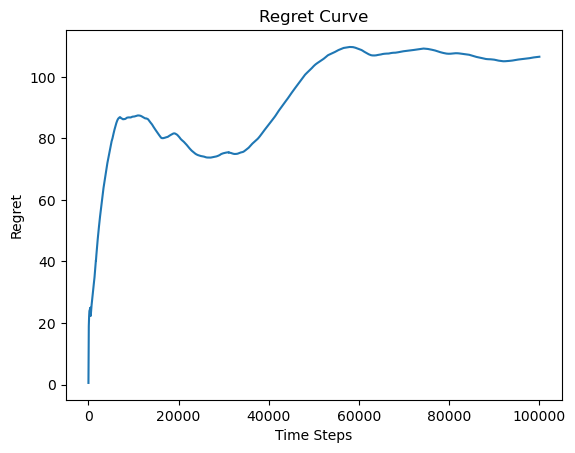

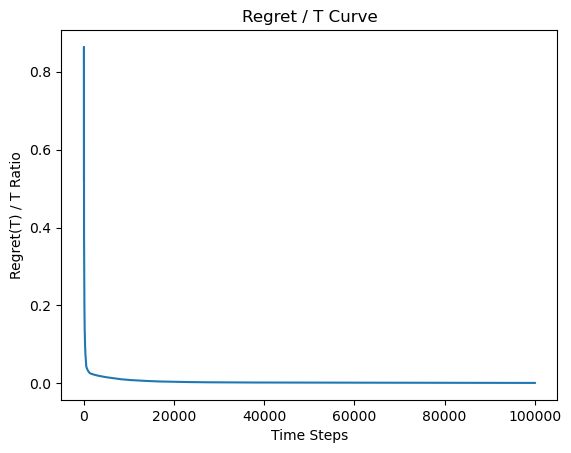

In [11]:
model3.plots()

<br><br>

## UCB (Upper Confidence Bound)

### Hoeffding UCB

In [12]:
class UCB:
    def __init__(self, means, T = 1000):
        if (T <= 0):
            print("Invalid Horizon Value! Using default value: T = 1000")
            T = 1000

        self.initialisation(means, T)
        self.round_robin()
        self.compute()
        self.optimal()

    def initialisation (self, means, T):
        self.T = T
        self.means = means
        self.n = len(means)
        
        self.total_reward = 0
        self.emp_mean = np.zeros(self.n)
        self.Na = np.zeros(self.n)
        self.x = np.array(range(self.T))
        self.y = np.zeros(self.T)

    def round_robin (self):
        for a in range(self.n):
            r = np.random.choice([0,1], p=[1 - self.means[a], self.means[a]])
            self.emp_mean[a] = r
            self.Na[a] = 1
            self.total_reward += r

    def compute (self):
        for t in range(self.T):
            a = np.argmax(self.emp_mean + np.sqrt((2*np.log(t+1))/self.Na))
            r = np.random.choice([0,1], p=[1 - self.means[a], self.means[a]])

            self.total_reward += r
            self.emp_mean[a] = (self.Na[a]*self.emp_mean[a] + r)/(self.Na[a] + 1)
            self.Na[a] += 1

            if (t == 0):
                self.y[t] = r
            else:
                self.y[t] = (t*self.y[t-1] + r)/(t+1)
            
    def optimal (self):
        a = np.argmax(self.emp_mean)
        print("The optimal Arm Number: ", a + 1, "\nMean_reward of optimal arm: ", self.means[a])

    def plots (self):
        learning_plot(self.x, self.y, max(self.means), np.mean(self.means))
        regret_plot(self.x, self.y, max(self.means))


In [13]:
model4 = UCB(mean_reward, T=100000)

The optimal Arm Number:  8 
Mean_reward of optimal arm:  0.6192709663506637


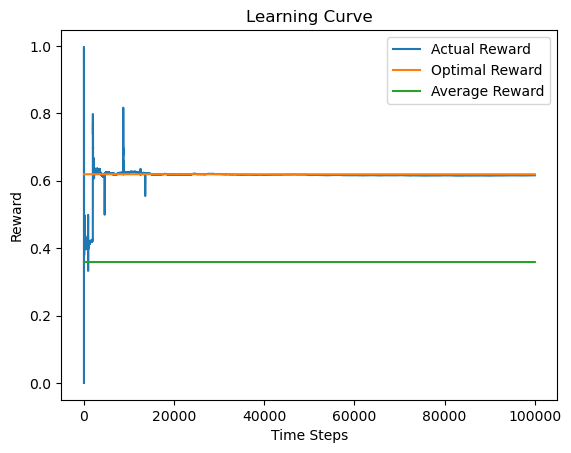

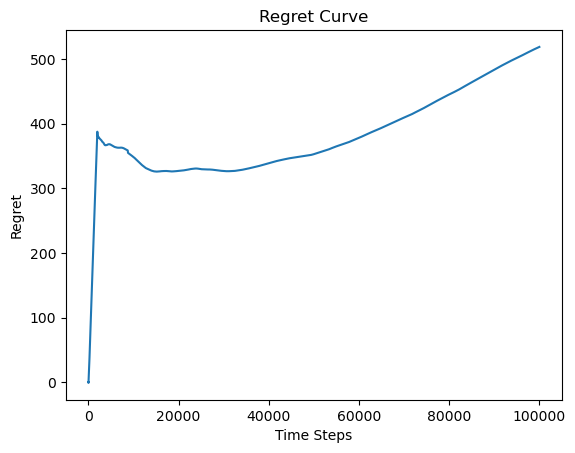

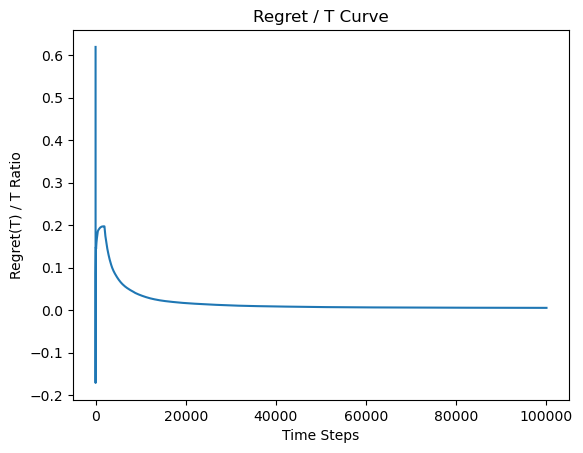

In [14]:
model2.plots()

### KL-UCB

<br> <br>

## Thompson Sampling

In [15]:
class ThompsonSampling:
    def __init__ (self, means, T = 1000):
        if (T <= 0):
            print("Invalid Horizon Value! Using default Horizon: T = 1000")
            T = 1000

        self.initialisation(means, T)
        self.round_robin()
        self.compute()
        self.optimal()

    def initialisation (self, means, T):
        self.T = T
        self.means = means
        self.n = len(means)
        self.s = np.zeros(self.n)
        self.f = np.zeros(self.n)

        self.total_reward = 0
        self.emp_mean = np.zeros(self.n)
        self.Na = np.zeros(self.n)
        self.x = np.array(range(self.T))
        self.y = np.zeros(self.T)

    def round_robin (self):
        for a in range(self.n):
            r = np.random.choice([0,1], p=[1 - self.means[a], self.means[a]])
            if (r == 1):
                self.s[a] += 1
            else:
                self.f[a] += 1

            self.Na[a] = self.s[a] + self.f[a]
            self.emp_mean[a] = r
            self.total_reward += r
    
    def compute (self):
        for t in range(self.T):
            a = np.argmax([np.random.beta(self.s[a] + 1, self.f[a] + 1) for a in range(n)])
            r = np.random.choice([0,1], p=[1 - self.means[a], self.means[a]])
            if (r == 1):
                self.s[a] += 1
            else:
                self.f[a] += 1

            self.total_reward += r
            self.emp_mean[a] = (self.Na[a]*self.emp_mean[a] + r) / (self.Na[a] + 1)
            self.Na[a] = self.s[a] + self.f[a]
            prob = self.s / self.Na

            if (t == 0):
                self.y[t] = r
            else:
                self.y[t] = (t*self.y[t-1] + r) / (t + 1)
            
    def optimal(self):
        opt_a = np.argmax(self.emp_mean)
        print("The optimal Arm Number: ", opt_a + 1, "\nMean_reward of optimal arm: ", self.emp_mean[opt_a])

    def plots(self):
        learning_plot(self.x, self.y, max(self.means), np.mean(self.means))
        regret_plot(self.x, self.y, max(self.means))
    

In [16]:
model5 = ThompsonSampling(mean_reward, T = 100000)

The optimal Arm Number:  8 
Mean_reward of optimal arm:  0.6193751327514095


In [17]:
dfx = pd.DataFrame({"Arms": np.array(range(1, n+1)), "Successes": model5.s, "Failures": model5.f, "Emperical Mean": model5.emp_mean, "True Mean": mean_reward})
dfx

,Arms,Successes,Failures,Emperical Mean,True Mean
0,1,9.0,23.0,0.281250,0.435995
1,2,0.0,11.0,0.000000,0.025926
2,3,523.0,389.0,0.573465,0.549662
3,4,8.0,22.0,0.266667,0.435322
4,5,0.0,11.0,0.000000,0.420368
5,6,7.0,22.0,0.241379,0.330335
6,7,2.0,14.0,0.125000,0.204649
7,8,61237.0,37632.0,0.619375,0.619271
8,9,21.0,33.0,0.388889,0.299655
9,10,15.0,31.0,0.326087,0.266827


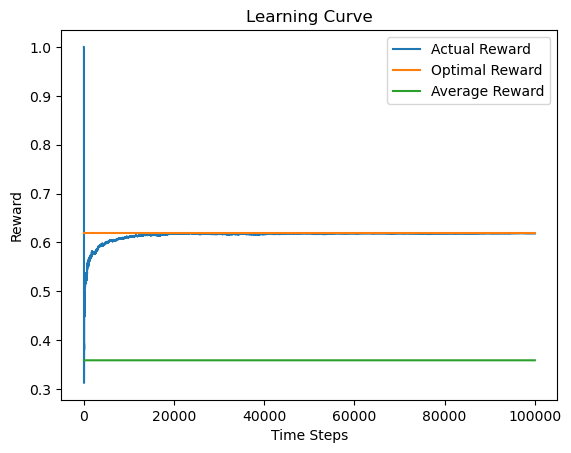

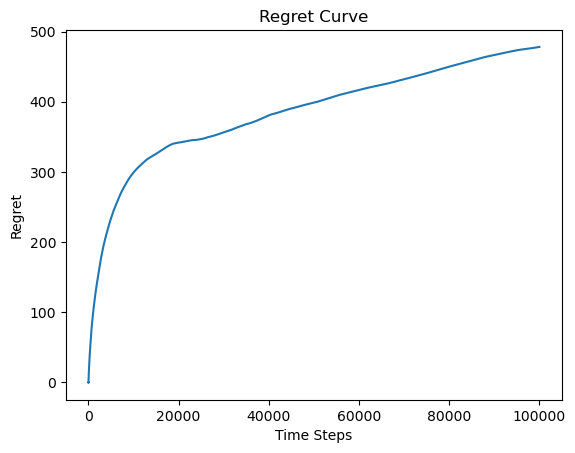

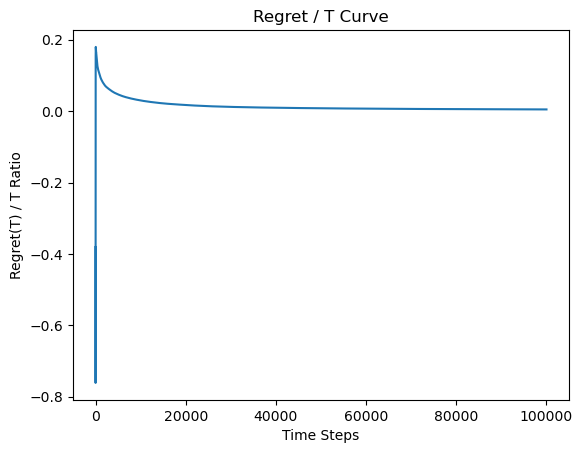

In [18]:
model5.plots()

<br><br>

## Gradient Bandit

In [19]:
class Gradient_Bandit:
    def __init__(self, means, T=1000, alpha=0.1):
        if (T <= 0):
            print("Invalid Horizon! Using default Horizon = 1000 Timesteps")
            T = 1000
        
        self.initialisation(means, T, alpha)
        self.compute()
        self.optimal()

    def initialisation (self, means, T, alpha):
        self.T = T
        self.means = means
        self.alpha = alpha
        self.n = len(means)
        self.H = np.zeros(self.n)
        self.prob = np.ones(self.n) / float(self.n)
        self.meanR = 0

        self.total_reward = 0
        self.emp_mean = np.zeros(self.n)
        self.Na = np.zeros(self.n)
        self.x = np.array(range(self.T))
        self.y = np.zeros(self.T)
    
    def compute(self):
        opta = np.argmax(self.prob)
        r = np.random.choice([0,1], p=[1 - self.means[opta], self.means[opta]])
        self.meanR = r
        self.total_reward = r
        for t in range(self.T):
            a = np.argmax(self.prob)
            r = np.random.choice([0,1], p=[1 - self.means[a], self.means[a]])
            self.meanR = ((t+1)*self.meanR + r)/(t+2)
            
            delta = np.zeros(n)
            delta[a] = 1
            self.H = [self.H[b] + self.alpha * (r - self.meanR) * (delta[b] - self.prob[b]) for b in range(n)]
            self.prob = [self.softmax(b) for b in range(n)]

            self.total_reward += r
            self.emp_mean[a] = (self.Na[a]*self.emp_mean[a] + r) / (self.Na[a] + 1)
            self.Na[a] += 1
            if (t == 0):
                self.y[t] = r
            else:
                self.y[t] = (t*self.y[t-1] + r)/(t+1)
    
    def softmax(self, a):
        num = np.exp(self.H[a])
        denom = np.squeeze(np.sum([np.exp(self.H[b]) for b in range(n)]))
        return num / denom

    def optimal(self):
        opt_a = np.argmax(self.emp_mean)
        print("The optimal Arm Number: ", opt_a + 1, "\nMean_reward of optimal arm: ", self.emp_mean[opt_a])

    def plots(self):
        learning_plot(self.x, self.y, max(self.means), np.mean(self.means))
        regret_plot(self.x, self.y, max(self.means))

In [25]:
model6 = Gradient_Bandit(mean_reward, T=100000)

The optimal Arm Number:  8 
Mean_reward of optimal arm:  0.618266018524074


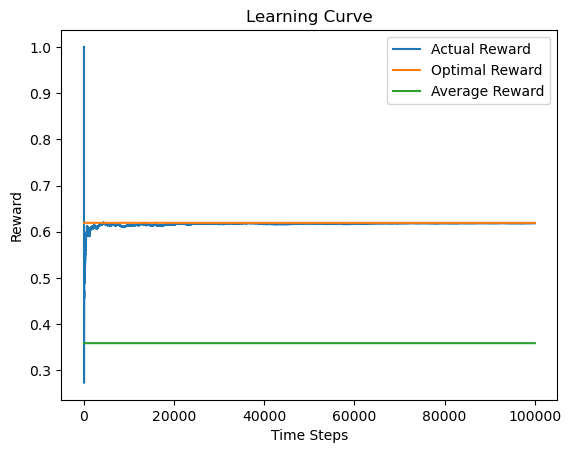

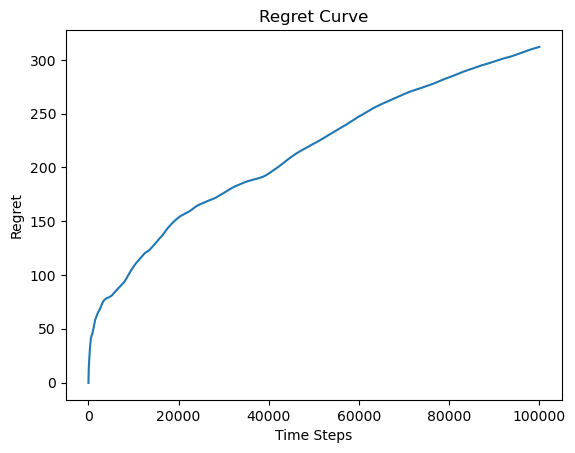

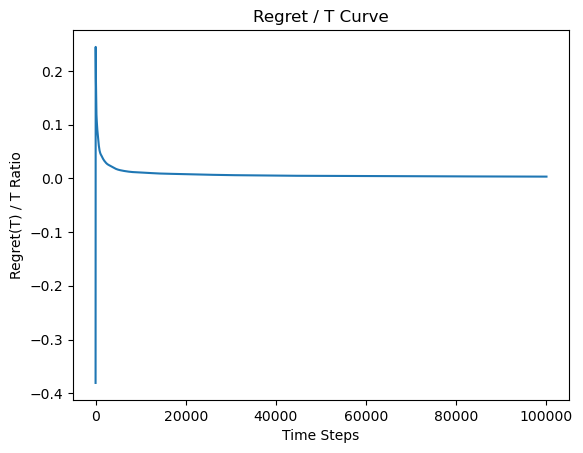

In [26]:
model6.plots()

<br><br>

## Performace Comparision

In [23]:
def regret_ratio (x, y, maxReward):
    ymax = maxReward * np.ones_like(y)
    regret = np.zeros(len(x))
    ratio = np.zeros(len(x))
    regret[0] = ymax[0] - y[0]
    ratio[0] = regret[0]
    for i in range(1, len(x)):
        regret[i] = regret[i-1] + (ymax[i] - y[i])
        ratio[i] = regret[i] / i
    return ratio

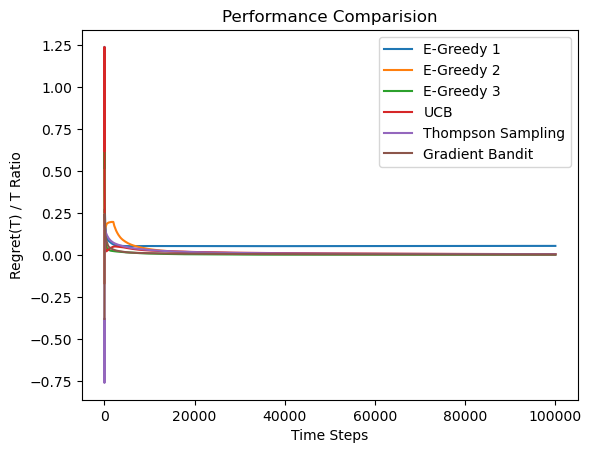

In [27]:
plt.figure()
plt.plot(model1.x, regret_ratio(model1.x, model1.y, max(mean_reward)))
plt.plot(model2.x, regret_ratio(model2.x, model2.y, max(mean_reward)))
plt.plot(model3.x, regret_ratio(model3.x, model3.y, max(mean_reward)))
plt.plot(model4.x, regret_ratio(model4.x, model4.y, max(mean_reward)))
plt.plot(model5.x, regret_ratio(model5.x, model5.y, max(mean_reward)))
plt.plot(model6.x, regret_ratio(model6.x, model6.y, max(mean_reward)))
plt.title("Performance Comparision")
plt.xlabel("Time Steps")
plt.ylabel("Regret(T) / T Ratio")
plt.legend(["E-Greedy 1", "E-Greedy 2", "E-Greedy 3", "UCB", "Thompson Sampling", "Gradient Bandit"])
plt.show()

#### Relative Performance of various models
$\epsilon$-Greedy 3 $\approx$ Gradient Bandit $\approx$ Thompson Sampling  $\approx$ $\epsilon$-Greedy 2  $\approx$ UCB  > $\epsilon$-Greedy 1
<br>

Sublinear Regret:
1. Thompson Sampling
2. $\epsilon$-Greedy 2
3. $\epsilon$-Greedy 3
4. UCB
5. Gradient Bandit
<br>

Linear Regret:
1. $\epsilon$-Greedy 1

#### Additional Comments
1. Gradient Bandits take longer computation time compared to other methods
2. $\epsilon$ - Greedy: Varient 3 does infinite exploration, but with such a low probability that in practice, it may converge to a sub-optimal arm